# Спрос на рынке жилья (за счет собственных средств)

In [1]:
from IPython.display import Markdown as md
import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.integrate import quad
from scipy.stats import rv_continuous, norm

%run ../COMMON/common.ipynb # загрузка общих функций и констант, все, что оттуда, должно иметь префикс common.

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strYearDBPath)) # connection к рабочей базе данных
conWorkEx = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strExYearDBPath)) # connection к к рабочей базе данных экзогенных переменных
conWorkExH=sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strExParamDBPath)) # connection к рабочей базе данных экзогенных параметров
conWorkSvod=sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strSvodDBPath)) # connection к рабочей базе данных СВОД


## Установка временных точек

In [2]:
iFirstFactYear=2008
iLastFactYear=2019

iFirstForecastYear=iLastFactYear+1
iLastForecastYear=2030

## Загрузка исходных данных

Исходные данные:
  - Фактические значения - из базы данных `year.sqlite3`;
  - Экзогенные - из базы данных `exog_year.sqlite3`
  - Задаваемые вручную - из базы данных `exog_param.sqlite3`
  - Результаты других моделей - из базы данных `svod.sqlite3`. *В эту же базу записываем результаты данного блокнота*. А даном блокноте используются результаты блока **"Цены и себестоимость"**

In [3]:
lstYearCodes=['squareddy_ss_x', 'CPIAv', 'Pop_x', 'HHAv', 'Unmpl_s', 'DispInc_rI', 'Inc_x', 'p_ProbDef', 
              'UZUss_x', 'MEPop', 'DispPop', 'LivMin', 'p_superrich', 'sdelkiddy_ss_x', 'sdelkikp_ss_x', 
             'squarekp_ss_x'] # список экзогенных и фактических данных
 

lstSvod=['price1mddy_alt_x', 'price1mall_alt_x', 'AvSqDdy', 'AvSqVtor'] # результаты из блока "Цены и себестоимость"

pdfAct=(pd.read_sql(common.make_SELECT_YEAR_string(lstYearCodes), con=conWork)
        .pipe(common.make_frame)
        .pipe(common.scale, list_fields=['Inc_x',], multiplier=1e3)
        .pipe(common.scale, list_fields=['sdelkiddy_ss_x',], multiplier=1e-6))
pdfExog=pd.read_sql(common.make_SELECT_YEAR_string(lstYearCodes), con=conWorkEx).pipe(common.make_frame)
PdfExogHandle=pd.read_sql(common.make_SELECT_YEAR_string(lstYearCodes), con=conWorkExH).pipe(common.make_frame)

pdfSvod=(pd.read_sql(common.make_SELECT_YEAR_string(lstSvod), con=conWorkSvod)
         .pipe(common.make_frame)
        .pipe(common.scale, list_fields=['price1mddy_alt_x', 'price1mall_alt_x'], multiplier=1e3))

pdfWork=pd.concat([pdfAct, pdfExog[~pdfExog.index.isin(pdfAct.index)]]).combine_first(PdfExogHandle).join(pdfSvod).pipe(common.scale, list_fields=['Unmpl_s',], multiplier=100)
pdfWork['_cnt_deal_om'] = pdfWork['sdelkiddy_ss_x'] + pdfWork['sdelkikp_ss_x']
pdfWork.sample(5).sort_index()

,CPIAv,DispPop,HHAv,Inc_x,LivMin,MEPop,Pop_x,UZUss_x,Unmpl_s,p_ProbDef,p_superrich,sdelkiddy_ss_x,sdelkikp_ss_x,squareddy_ss_x,squarekp_ss_x,AvSqDdy,AvSqVtor,price1mall_alt_x,price1mddy_alt_x,_cnt_deal_om
date,,,,,,,,,,,,,,,,,,,,
2004,1.108812,NaN,2.677054,6410.3,2376.0,NaN,144.067300,NaN,7.714864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,1.127055,0.756100,2.661470,8088.3,3018.0,8.711611,143.518814,NaN,7.153243,NaN,0.02,0.143936,1.334440,NaN,NaN,65.703978,NaN,21048.567265,18491.692819,1.478376
2019,1.044779,0.764492,2.386583,35249.3,10890.0,10.176471,146.764655,13.958602,4.595309,0.03,0.02,0.304496,1.690836,16.106917,88.265098,49.401114,52.173384,60549.798447,53625.435044,1.995332
2031,1.039028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.684579,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034,1.039028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.684579,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Потенциальный спрос на жилье (без лага с весом 0.5, с лагом 1 год с весом 0.5) - _PDHouses_w   

В расчете используются следующие переменные (формулы переменных приведены ниже):
  - Потенциальный спрос - **\_PD** (блок 1.1)
  - Типовая покупка жилья сверхбогатым населением в год на чел - **\_superrich\_buy** (блок 1.2) 
  - Доля семей, фактически улучшивших жилищные условия за скользящие 7 лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % - **\_p\_self\_improve** (блок 1.3)
  - Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий - **\_Calc\_PD\_FH\_OM\_Corr** (блок 1.4)
  -  Потенциальный спрос на жилье - **_PDHouses_w** (блок 1.4)

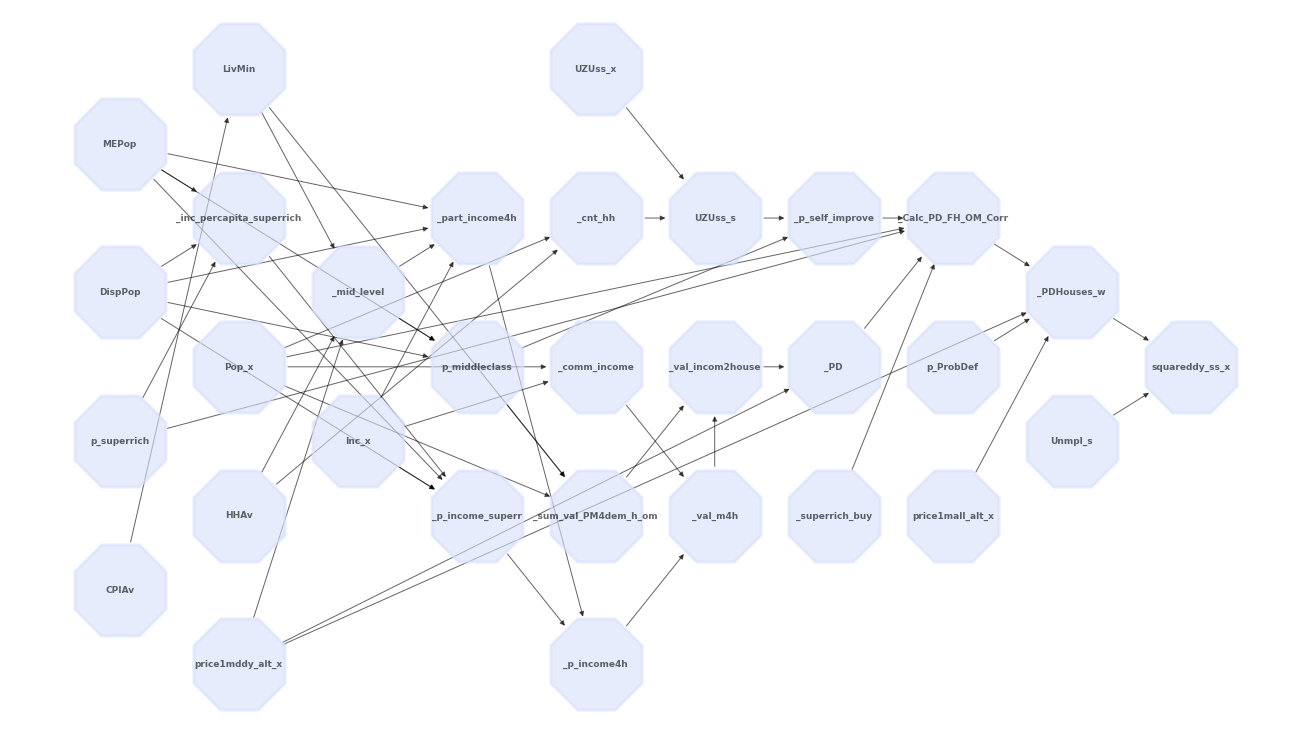

<details>
<table align=left border="1">
<tr><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Загружаем из-вне</td><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Загружаем и считаем</td><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Считаем</td></tr>
<tr><td style="vertical-align:top">
    <table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">CPIAv</td><td style="text-align:left">ИПЦ, в среднем за год</td></tr>
    <tr><td style="text-align:left;font-weight:bold">Pop_x</td><td style="text-align:left">Численность населения (среднегодовая)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">HHAv</td><td style="text-align:left">Средний размер домохозяйства</td></tr>
    <tr><td style="text-align:left;font-weight:bold">Unmpl_s</td><td style="text-align:left">Уровень безработицы</td></tr>
    <tr><td style="text-align:left;font-weight:bold">Inc_x</td><td style="text-align:left">Среднедушевые денежные доходы населения (в текущих ценах)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_ProbDef</td><td style="text-align:left">Вероятность дефолта проекта и/или застройщика</td></tr>
    <tr><td style="text-align:left;font-weight:bold">price1mddy_alt_x</td><td style="text-align:left">Средняя цена 1 кв. м по ДДУ</td></tr>
    <tr><td style="text-align:left;font-weight:bold">price1mall_alt_x</td><td style="text-align:left">Средняя цена 1 кв. м на рынке готового жилья</td></tr>
    <tr><td style="text-align:left;font-weight:bold">MEPop</td><td style="text-align:left">Параметр $\mu$ нормального распределения и распределения Колмакова</td></tr>
    <tr><td style="text-align:left;font-weight:bold">DispPop</td><td style="text-align:left">Параметр $\sigma$ нормального распределения и распределения Колмакова</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_superrich</td><td style="text-align:left">Доля сверхбогатого населения</td></tr>
    </table>
</td><td style="vertical-align:top">
    <table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">squareddy_ss_x</td><td style="text-align:left">Модель 1 Площадь строящегося жилья, приобретенного за счет собственных средств - факт</td></tr>
    <tr><td style="text-align:left;font-weight:bold">LivMin</td><td style="text-align:left">Прожиточный минимум</td></tr>
    <tr><td style="text-align:left;font-weight:bold">UZUss_x</td><td style="text-align:left">Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет</td></tr>
            <tr><td style="text-align:left;font-weight:bold">sdelkiddy_ss_x</td><td style="text-align:left">Количество сделок с ДДУ/Эскроу</td></tr>
    <tr><td style="text-align:left;font-weight:bold">sdelkikp_ss_x</td><td style="text-align:left">Количество сделок по договорам купли-продажи</td></tr>
    </table>
</td>
    <td style="vertical-align:top">
<table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">_PDHouses_w</td><td style="text-align:left">Потенциальный спрос на жилье</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_self_improve</td><td style="text-align:left">Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, %</td></tr>
    <tr><td style="text-align:left;font-weight:bold">UZUss_s</td><td style="text-align:left">Доля семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_cnt_hh</td><td style="text-align:left">Число домохозяйств</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_Calc_PD_FH_OM_Corr</td><td style="text-align:left">Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_PD</td><td style="text-align:left">Потенциальный спрос</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_val_incom2house</td><td style="text-align:left">Общий объем денежных доходов, которые могут потратить на жилье</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_comm_income</td><td style="text-align:left">Общий объем денежных доходов населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_val_m4h</td><td style="text-align:left">Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_sum_val_PM4dem_h_om</td><td style="text-align:left">Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_mid_level</td><td style="text-align:left">Порог</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_part_income4h</td><td style="text-align:left">Доля денежных доходов, которые могут потратить на жилье (включая ПМ)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_middleclass</td><td style="text-align:left">Доля населения с доходами выше порога</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_superrich_buy</td><td style="text-align:left">Типовая покупка жилья сверхбогатым населением в год на чел</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_inc_percapita_superrich</td><td style="text-align:left">Среднедушевые доходы сверхбогатого населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_income_superr</td><td style="text-align:left">Доля доходов сверхбогатого населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_income4h</td><td style="text-align:left">Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения</td></tr>
        <tr><td style="text-align:left;font-weight:bold">_cnt_deal_om</td><td style="text-align:left">Количество сделок по покупке жилья за счет собственных средств на первичном и вторичном рынках</td></tr>
    </table>
    </td></tr>
</table>
</details>

### 1.1 Расчет  Потенциального спроса (\_PD)

Для расчета Потенциального спроса (\_PD) необходимо расчитать следующие переменные:
  - \_comm\_income - Общий объем денежных доходов населения
  - \_part\_income4h - Общего объема денежных доходов, которые могут потратить на жилье (включая ПМ)
  - p\_middleclass - Доля населения с доходами выше порога
  - LivMin - Прожиточный минимум
  - \_val\_m4h - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ)
  - \_sum\_val\_PM4dem\_h\_om - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств

а так же переменных, используемых в расчете переменных выше
  - \_p\_income\_superr - Доля доходов сверхбогатого населения
  - \_mid\_level - Порог
  - \_p\_income4h - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения
  - \_inc\_percapita\_superrich - Среднедушевые доходы сверхбогатого населения

#### 1.1.1 Доля доходов сверхбогатого населения (переменная \_p\_income\_superr)

Для расчета используются следующие входные данные:
  - Среднедушевые денежные доходы населения (в текущих ценах) - *Inc\_x*, загружаются из базы данных
  - Параметр $\mu$ (матожидание) распределения **доходов населения** по уровню среднедушевого среднемесячного денежного дохода в денежном выражении - *MEPop*. ОДновременно это параметр $\mu$ для нормального распределения **населения** по уровню денежных доходов, полученного из логнормального распределения населения по уровню среднедушевых доходов - **данные из ДОМ.РФ**
  - Параметр $\sigma$ (среднеквадратичное отклонение) распределения **доходов населения** по уровню среднедушевого среднемесячного денежного дохода в денежном выражении - *DispPop*. ОДновременно это параметр $\sigma$ для нормального распределения **населения** по уровню денежных доходов, полученного из логнормального распределения населения по уровню среднедушевых доходов - **данные из ДОМ.РФ**
  - Доля сверхбогатого населения - *p_superrich*, загружается из базы данных (наша гипотеза?)
  
**Алгоритм расчета:**
  1. Определяем *Среднедушевые доходы сверхбогатого населения* - *\_inc\_percapita\_superrich*   
  
  $\_inc\_percapita\_superrich=\large{e^{{\mathcal{N}(MEPop,\,DispPop^{2}).ppf(1-p\_superrich)}}} $    
  
  
  где ppf - Percent point function (inverse of cdf — percentiles) **нормального распределения** $\mathcal{N}(MEPop,\,DispPop^{2})   $
  
  2. Полученную величину \_inc\_percapita\_superrich используем в качестве X для нахождения доли *доходов сверхбогатого населения (переменная _p_income_superr)* по распределению *доходов населения по уровню среднедушевого среднемесячного денежного дохода в денежном выражении* - [И.Б. Колмаков "Методология расчета и анализа интегральных оценок показателей поляризации денежных доходов населения"](https://voprstat.elpub.ru/jour/article/view/189?locale=ru_RU). 
  pdf (Probability density function) этого распределения имеет вид:
  
   $kolmakov.pdf(x, \sigma, \mu) = \displaystyle\frac{1}{\sigma \sqrt{2\pi}}
                  \exp\left(-\frac{(\log(x)-\mu)^2}{2\sigma^2}\right)$
                  
   искомая величина  
   $ \_p\_income\_superr = 1-\displaystyle{\frac{kolmakov.cdf(x, \sigma, \mu)}{Inc\_x}}$
   
   где kolmakov.cdf - сumulative distribution function для распределения выше (интеграл от 0 до x по кривой распределения) с параметрами $\sigma = DispPop$ и $\mu = MEPop$ 

In [4]:
class kolmakov_gen(rv_continuous):
    """ Распределения доходов населения по уровню среднедушевого среднемесячного денежного дохода в денежном выражении """
        
    def _pdf(self, x, sigma, mu):
        Px = np.exp(-(np.log(x)-mu)**2 / (2*sigma**2))
        return Px / (sigma*np.sqrt(2*np.pi))
#         return lognorm.pdf(x, s=sigma, scale=np.exp(mu)) * x
    
    def _cdf(self, x, sigma, mu):
        return quad(self._pdf, 0, x, args=(sigma, mu))[0] 


kolmakov = kolmakov_gen(a=0.0, name='kolmakov', shapes='sigma, mu')

In [5]:
def _calc_superrich_perca_income(x):
    return 1-kolmakov.cdf(x['_inc_percapita_superrich'], sigma=x['DispPop'], mu=x['MEPop'])/x['Inc_x']

pdfWork['_inc_percapita_superrich']=np.exp(norm.ppf(1-pdfWork['p_superrich'], loc=pdfWork['MEPop'], scale=pdfWork['DispPop']))

pdfWork['_p_income_superr']=pdfWork[['_inc_percapita_superrich', 'DispPop', 
                                     'MEPop', 'Inc_x']].apply(_calc_superrich_perca_income, axis=1)

pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_inc_percapita_superrich', 'DispPop', 'MEPop', 'Inc_x', '_p_income_superr']]

,_inc_percapita_superrich,DispPop,MEPop,Inc_x,_p_income_superr
date,,,,,
2015,109395.951680,0.765043,10.031523,30254.400000,0.092627
2016,110193.168853,0.763400,10.042158,30865.000000,0.101911
2017,112229.017148,0.759399,10.068682,31896.500000,0.109627
2018,119197.560879,0.765300,10.116803,33178.100000,0.098795
2019,126316.337878,0.764492,10.176471,35249.300000,0.100011
2020,126447.584124,0.764492,10.177509,35154.629192,0.096650


#### 1.1.2 Доля населения с доходами выше порога - p_middleclass, Порог - \_mid\_level и Прожиточный минимум - LivMin
<br>   
Расчет доли населения с доходами выше порога делаем аналогично расчету доли сверхбогатого населения 

&emsp;&emsp;&emsp;  $p\_middleclass=1-{\mathcal{N}(MEPop,\,DispPop^{2}).cdf(\_mid\_level)} $    
  
&emsp;  где cdf - umulative distribution function **нормального распределения** $\mathcal{N}(MEPop,\,DispPop^{2})   $

но величину порогового дохода - \_mid\_level (Х для нормального распределения населения по доходам, полученного из логнормального), определяем от:
  - LivMin - Прожиточного минимума (**загружаем из базы данных, расчитываем**)
  - HHAv - Среднего размера  домохозяйства (**из базы данных**)
  - price1mddy\_alt\_x - Средняя цена 1 кв. м по ДДУ (**из другого блока**)
  
  $\begin{equation*}
    LivMin =  
     \begin{cases}
       LivMin_y; \quad \text{при y < прогнозных годов} \\
       LivMin_{y-1} * CPIAv \quad \text{при y>= прогнозных годов }
     \end{cases}
\end{equation*}$

  где CPIAv - ИПЦ, в среднем за год (**из базы данных**)
  
  $\_mid\_level = LivMin + \left({\frac{\frac{\large\frac{54}{12}}{\large HHAv}}{\large 7}}\right) * price1mddy\_alt\_x $

In [18]:
idxnan = pdfWork['LivMin'].last_valid_index()
pdfWork.loc[idxnan:, 'LivMin']=pdfWork['LivMin'].combine_first(pdfWork['CPIAv']).loc[idxnan:].cumprod()

pdfWork['_mid_level']=pdfWork['LivMin'] + (54 / 12 / pdfWork['HHAv'] / 7) * pdfWork['price1mddy_alt_x']
pdfWork['p_middleclass']=1-norm.cdf(np.log(pdfWork['_mid_level']), loc=pdfWork['MEPop'], scale=pdfWork['DispPop'])

pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['CPIAv', 'LivMin', 'price1mddy_alt_x', 'HHAv', '_mid_level', 'p_middleclass']]

,CPIAv,LivMin,price1mddy_alt_x,HHAv,_mid_level,p_middleclass
date,,,,,,
2015,1.155546,9701.000000,48153.946670,2.386583,22671.890766,0.501378
2016,1.070664,9828.000000,47585.730100,2.386583,22645.834255,0.507539
2017,1.036931,10088.000000,47804.624458,2.386583,22964.796293,0.514162
2018,1.028759,10287.000000,49884.125622,2.386583,23723.936931,0.522176
2019,1.044779,10890.000000,53625.435044,2.386583,25334.707201,0.519061
2020,1.033015,11249.529243,63369.379920,2.386583,28318.894512,0.461561


#### 1.1.3 Доля денежных доходов, которые могут потратить на жилье (включая ПМ) - \_part\_income4h	

&emsp;&emsp;&emsp; $ \_part\_income4h = 1-\displaystyle{\frac{kolmakov.cdf(\_mid\_level)}{Inc\_x}}$
   
   где 
   - kolmakov.cdf - сumulative distribution function для распределения доходов населения по уровню среднедушевого среднемесячного денежного дохода в денежном выражении (см. выше) с параметрами $\mu=MEPop$ и $\sigma = DispPop$
   - \_mid\_level - порог (считаем выше)
   - Inc\_x - Среднедушевые денежные доходы населения (в текущих ценах) (из базы данных)

In [19]:
def _calc_part_income4h(x):
    return 1-kolmakov.cdf(x['_mid_level'], sigma=x['DispPop'], mu=x['MEPop'])/x['Inc_x']

pdfWork['_part_income4h']=pdfWork[['_mid_level', 'DispPop', 'MEPop', 'Inc_x']].apply(_calc_part_income4h, axis=1)

pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_part_income4h', 'DispPop', 'MEPop', '_mid_level', 'Inc_x']]

,_part_income4h,DispPop,MEPop,_mid_level,Inc_x
date,,,,,
2015,0.777402,0.765043,10.031523,22671.890766,30254.400000
2016,0.783810,0.763400,10.042158,22645.834255,30865.000000
2017,0.789469,0.759399,10.068682,22964.796293,31896.500000
2018,0.794153,0.765300,10.116803,23723.936931,33178.100000
2019,0.792000,0.764492,10.176471,25334.707201,35249.300000
2020,0.747369,0.764492,10.177509,28318.894512,35154.629192


#### 1.1.4 Общий объем денежных доходов населения -\_comm\_income и Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения - \_p\_income4h

$ \_comm\_income = \large \frac{Inc\_x * 12 * Pop\_x}{1000} $ 
  
  
$ \_p\_income4h = \_part\_income4h - \_p\_income\_superr $

In [20]:
pdfWork['_comm_income'] = pdfWork['Inc_x'] * 12 * pdfWork['Pop_x'] / 1e3
pdfWork['_p_income4h'] = pdfWork['_part_income4h'] - pdfWork['_p_income_superr']

pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_comm_income', '_p_income4h', 'Inc_x', 'Pop_x']]

,_comm_income,_p_income4h,Inc_x,Pop_x
date,,,,
2015,53153.107874,0.684775,30254.400000,146.405999
2016,54325.316496,0.681898,30865.000000,146.674541
2017,56205.103722,0.679842,31896.500000,146.842401
2018,58458.714005,0.695358,33178.100000,146.830575
2019,62080.216242,0.691989,35249.300000,146.764655
2020,61885.932914,0.650719,35154.629192,146.699345


#### 1.1.5  Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ) - \_val\_m4h и Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств - \_sum\_val\_PM4dem\_h\_om
 
$\displaystyle \_val\_m4h = \_p\_income4h * \_comm\_income$ 

где
  - \_p\_income4h - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения (**считаем выше**)
  - \_comm\_income - Общий объем денежных доходов населения (**считаем выше**)
  
$ \_sum\_val\_PM4dem\_h\_om = \displaystyle \frac{12 * LivMin * p\_middleclass * Pop\_x}{1000}$

где
  - LivMin - Прожиточный минимум (**считаем выше**)
  - p_middleclass - Доля населения с доходами выше порог (**считаем выше**)

In [21]:
pdfWork['_val_m4h'] = pdfWork['_comm_income'] * pdfWork['_p_income4h']
pdfWork['_sum_val_PM4dem_h_om'] = 12 * pdfWork['LivMin'] * pdfWork['p_middleclass'] * pdfWork['Pop_x'] / 1e3


pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_val_m4h', '_sum_val_PM4dem_h_om', '_comm_income', '_p_income4h', 'LivMin' ,'Pop_x']]

,_val_m4h,_sum_val_PM4dem_h_om,_comm_income,_p_income4h,LivMin,Pop_x
date,,,,,,
2015,36397.916445,8545.187985,53153.107874,0.684775,9701.000000,146.405999
2016,37044.350658,8779.509547,54325.316496,0.681898,9828.000000,146.674541
2017,38210.586500,9139.825568,56205.103722,0.679842,10088.000000,146.842401
2018,40649.747330,9464.630338,58458.714005,0.695358,10287.000000,146.830575
2019,42958.840812,9955.173404,62080.216242,0.691989,10890.000000,146.764655
2020,40270.367052,9140.555831,61885.932914,0.650719,11249.529243,146.699345


#### 1.1.6 Расчет Общего объема денежных доходов, которые могут потратить на жилье - \_val\_incom2house <br>и Потенциального спроса - \_PD

<br>
<center>$\_PD = \dfrac{\_val\_incom2house * 1000}{price1mddy\_alt\_x}$</center>

где 
  - \_val\_incom2house - Общий объем денежных доходов, которые могут потратить на жилье (**считаем выше**)
  - price1mddy\_alt\_x - Средняя цена 1 кв. м по ДДУ (**из другого блока**)
  
  $ \_val\_incom2house = \_val\_m4h - \_sum\_val\_PM4dem\_h\_om $
  
где
  - \_val\_m4h - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ) (**считаем выше**)
  - \_sum\_val\_PM4dem\_h\_om - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств (**считаем выше**)

In [22]:
pdfWork['_val_income2house'] = pdfWork['_val_m4h'] - pdfWork['_sum_val_PM4dem_h_om']
pdfWork['_PD'] = pdfWork['_val_income2house'] * 1e3 / pdfWork['price1mddy_alt_x']

pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_PD', '_val_income2house', '_val_m4h', '_sum_val_PM4dem_h_om']]

,_PD,_val_income2house,_val_m4h,_sum_val_PM4dem_h_om
date,,,,
2015,578.410087,27852.728461,36397.916445,8545.187985
2016,593.977250,28264.841111,37044.350658,8779.509547
2017,608.116082,29070.760932,38210.586500,9139.825568
2018,625.151120,31185.116992,40649.747330,9464.630338
2019,615.448012,33003.667408,42958.840812,9955.173404
2020,491.243740,31129.811221,40270.367052,9140.555831


### 1.2 Типовая покупка жилья сверхбогатым населением в год на чел - \_superrich\_buy
$ \begin{equation*}
\_superrich\_buy =  
 \begin{cases}
   \dfrac{34.71428571}{HHAv_{2008}}; \quad \text{при} \quad 2008<= y <= 2024\\
   \_superrich\_buy_{2024} + \dfrac{\_superrich\_buy_{2030} - \_superrich\_buy_{2024}}{6}\;\;\;;  \quad \text{при} \quad y=2025\\
   2 * \_superrich\_buy_{y-1} - \_superrich\_buy_{y-2};  \quad \text{при} \quad 2025<y<2030\\
   0; \quad \text{при} \quad y=2030
 \end{cases}
\end{equation*} $  

где HHAv - Средний размер домохозяйства (**из базы данных**)

In [23]:
pdfWork['_superrich_buy']=4.5*54/7/pdfWork.loc[iFirstFactYear, 'HHAv']
pdfWork.loc[iFirstForecastYear, '_superrich_buy']=0
pdfWork.loc[2025, '_superrich_buy']= pdfWork.loc[2024, '_superrich_buy'] + (pdfWork.loc[iFirstForecastYear, '_superrich_buy']-pdfWork.loc[2024, '_superrich_buy'])/6

for i in range(2026, 2030):
    pdfWork.loc[i, '_superrich_buy']=2*pdfWork.loc[i-1, '_superrich_buy'] - pdfWork.loc[i-2, '_superrich_buy']

pdfWork.loc[iLastFactYear:iFirstForecastYear, ['_superrich_buy']]

,_superrich_buy
date,
2019,13.276496
2020,0.000000


### 1.3 Доля семей, фактически улучшивших жилищные условия за скользящие 7 лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % - \_p\_self\_improve

$ \_p\_self\_improve = \large\frac{UZUss\_s}{p\_middleclass} $

где
  - UZUss\_s - Доля семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет (**расчет**)
  - p\_middleclass - Доля населения с доходами выше порога (**расчет**)
  
#### 1.2.1 Доля семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет - UZUss\_s

$ UZUss\_s = \large\frac{UZUss\_x}{\_cnt\_hh}$

где
  - UZUss\_x - Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет (**из базы данных**))
  - \_cnt\_hh - Число домохозяйств
  
  $ \_cnt\_hh = \large\frac{Pop\_x}{HHAv} $
  
где
  - Pop\_x - Численность населения (среднегодовая) (**из базы данных**))
  - HHAv - Средний размер домохозяйства (**из базы данных**))
  
<div class="alert alert-block alert-warning">
    UZUss_x - Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет существуют только для фактических значений. Для прогнозных значений этот показатель расчитывается через модель № 1 "Площадь строящегося жилья, приобретенного за счет собственных средств"<br>
    Т.е. для прогнозных годов этот показатель расчитывается от предидущего года по модели, и используется в качестве регрессора модели для расчета следующего года<br>
    Коэффициенты для модели оцениваются по фактичким значеним - они беруться из базы данных
</div>

In [24]:
pdfWork['_cnt_hh'] = pdfWork['Pop_x']/pdfWork['HHAv']
pdfWork['UZUss_s'] = pdfWork['UZUss_x'] / pdfWork['_cnt_hh']
pdfWork['_p_self_improve'] = pdfWork['UZUss_s'] / pdfWork['p_middleclass']
pdfWork['_p_self_improve']=pdfWork['_p_self_improve'].bfill()
# pdfWork.loc[pdfWork['_p_self_improve'].first_valid_index() -1, '_p_self_improve']=
pdfWork.loc[iLastFactYear-2:iFirstForecastYear, ['_p_self_improve', '_cnt_hh', 'Pop_x', 'HHAv', 'UZUss_x', 'UZUss_s', 'p_middleclass']]

,_p_self_improve,_cnt_hh,Pop_x,HHAv,UZUss_x,UZUss_s,p_middleclass
date,,,,,,,
2017,0.461675,61.528300,146.842401,2.386583,14.605321,0.237376,0.514162
2018,0.443328,61.523345,146.830575,2.386583,14.242377,0.231495,0.522176
2019,0.437299,61.495724,146.764655,2.386583,13.958602,0.226985,0.519061
2020,NaN,61.468358,146.699345,2.386583,NaN,NaN,0.461561


### 1.4 Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий - \_Calc\_PD\_FH\_OM\_Corr  и Потенциального спроса на житье (без лага с весом 0.5, с лагом 1 год с весом 0.5) - _PDHouses_w   (регрессор модели)
<br>

<center>$\_Calc\_PD\_FH\_OM\_Corr = \_PD+p\_superrich \cdot \_superrich\_buy \cdot Pop\_x \cdot (1-\_p\_self\_improve_{y-1})$</center>
<br>   
   
   
<center>$ \_PDHouses\_w = \ln \left( \dfrac{\_Calc\_PD\_FH\_OM\_Corr_{y-1} \cdot 0.5 + \_Calc\_PD\_FH\_OM\_Corr_y \cdot 0.5}{(1 + p\_ProbDef) \dfrac{price1mddy\_alt\_x}{price1mall\_alt\_x}} \right)$</center>

### 1.5 ...и добавляем дамми

In [25]:
pdfWork=pdfWork.loc[iFirstFactYear-1:, :]

pdfWork['_Calc_PD_FH_OM_Corr'] = (pdfWork['_PD'] + pdfWork['p_superrich'] * pdfWork['_superrich_buy'] 
                                  * pdfWork['Pop_x']) * (1 - pdfWork['_p_self_improve'].shift(1))

pdfWork['_PDHouses_w']=(np.log( 
    (pdfWork['_Calc_PD_FH_OM_Corr'].shift(1)*0.5 + pdfWork['_Calc_PD_FH_OM_Corr']*0.5) 
    / ((1+pdfWork['p_ProbDef']) * pdfWork['price1mddy_alt_x'] / pdfWork['price1mall_alt_x']) )
    )

pdfWork['D']=0
pdfWork.loc[ (2014, 2019), 'D']=1
pdfWork[['_PDHouses_w', '_Calc_PD_FH_OM_Corr', '_PD', 'p_superrich', '_superrich_buy', 'Pop_x', '_p_self_improve', 'p_ProbDef', 'D']].dropna()

,_PDHouses_w,_Calc_PD_FH_OM_Corr,_PD,p_superrich,_superrich_buy,Pop_x,_p_self_improve,p_ProbDef,D
date,,,,,,,,,
2009,5.395987,229.236901,394.144941,0.02,13.276496,142.785348,0.437808,0.10,0
2010,5.615056,287.937369,474.238226,0.02,13.276496,142.849468,0.420668,0.10,0
2011,5.767168,306.700655,491.443309,0.02,13.276496,142.960908,0.436982,0.10,0
2012,5.827185,310.723911,513.865245,0.02,13.276496,143.201721,0.447104,0.10,0
2013,5.855479,320.774621,542.065980,0.02,13.276496,143.506995,0.448079,0.10,0
2014,5.881504,325.332256,550.663152,0.02,13.276496,146.090613,0.461305,0.10,1
2015,5.881621,332.528273,578.410087,0.02,13.276496,146.405999,0.459945,0.10,0
2016,5.890488,341.813495,593.977250,0.02,13.276496,146.674541,0.468311,0.10,0
2017,5.892738,344.059840,608.116082,0.02,13.276496,146.842401,0.461675,0.10,0


## 2. Оценка модели  1 - Площадь строящегося жилья, приобретенного за счет собственных средств

**Регрессоры:**
  - Потенциальный спрос на жилье (без лага с весом 0.5, с лагом 1 год с весом 0.5) - \_PDHouses\_w (**расчетный**)
  - Уровень безработицы - Ln(Unmpl\_s) (**из базы данных**)
  - Дамми-переменная на 2014 и 2019 гг. 
     <br><br>   
<center>  $\large squareddy\_ss\_x \sim \_PDHouses\_w + Ln(Unmpl\_s) + D_{(2014, 2019)} - 1 $  </center>


In [26]:
pdfXY = pdfWork.loc[iFirstFactYear:iLastFactYear, [ 'squareddy_ss_x', 'Unmpl_s', 'D', '_PDHouses_w']].dropna()

resSSSX = smf.ols(formula='squareddy_ss_x ~_PDHouses_w + np.log(Unmpl_s) + D - 1', missing='drop', data=pdfXY).fit()
print(resSSSX.summary())

                                 OLS Regression Results                                
Dep. Variable:         squareddy_ss_x   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              158.3
Date:                Fri, 05 Feb 2021   Prob (F-statistic):                    8.55e-07
Time:                        17:09:42   Log-Likelihood:                         -18.130
No. Observations:                  10   AIC:                                      42.26
Df Residuals:                       7   BIC:                                      43.17
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

# Расчет окончательного результата Модели 1

На **прогнозном отрезке** UZUss_x расчитывается по формуле:

$ UZUss\_x_y = \displaystyle\sum\limits_{i=y-7}^y{\_cnt\_deal\_om_i}$

$ \_cnt\_deal\_om = sdelkidd\_ss\_x + sdelkikp\_ss\_x $

$ sdelkidd\_ss\_x = \displaystyle\frac{squareddy\_ss\_x}{AvSqDdy}\quad; \qquad sdelkikp\_ss\_x = \displaystyle\frac{squarekp\_ss\_x}{AvSqVtor}$

где 
  - \_cnt\_deal\_om - Количество сделок по покупке жилья за счет собственных средств на первичном и вторичном рынках
  - sdelkidd\_ss\_x - Количество сделок с ДДУ/Эскроу
  - sdelkikp\_ss\_x - Количество сделок по договорам купли-продажи
  - AvSqDdy - Средняя площадь квартиры, приобретаемой по ДДУ/Эскроу (на этапе строительства), кв. м (**из СВОДА**)
  - AvSqVtor - Средняя площадь квартиры, приобретаемой на вторичном рынке, кв. м (**из СВОДА**)
  - squareddy\_ss\_x - Площадь строящегося жилья, приобретенного за счет собственных средств (**результат Молели 1 этого блокнота**)
  - squarekp\_ss\_x - Площадь готового жилья, приобретенного за счет собственных средств (**результат Молели 2 этого блокнота**)

Дальше расчитываем $ \_p\_self\_improve = \large\frac{UZUss\_s}{p\_middleclass} $, \_Calc\_PD\_FH\_OM\_Corr и \_PDHouses\_w - предиктор Модели 1

Однако переменная \_p\_self\_improve входит в формулу расчета предиктора с лагом 1 год - то есть **для расчета текущего значения предиктора используются результаты моделирования для предидущего года**


In [30]:
# ЗАГЛУШКА!!!!
# ТУТ БУДЕТ РЕЗУЛЬТАТ ВРОТОЙ МОДЕЛИ

pdfWork.loc[iFirstForecastYear:iLastForecastYear, 'squarekp_ss_x'] = [109.3, 104.4, 95.6, 101.4, 
99.3, 111.0, 113.0, 123.0, 127.2, 137.5, 139.7]
pdfWork.head(5)

,CPIAv,DispPop,HHAv,Inc_x,LivMin,MEPop,Pop_x,UZUss_x,Unmpl_s,p_ProbDef,...,_sum_val_PM4dem_h_om,_val_income2house,_PD,_superrich_buy,_cnt_hh,UZUss_s,_p_self_improve,_Calc_PD_FH_OM_Corr,_PDHouses_w,D
date,,,,,,,,,,,,,,,,,,,,,
2007,1.089881,0.785663,2.630302,12540.2,3847.0,9.129498,142.805114,NaN,6.029393,0.1,...,2470.024245,9948.787775,303.632341,13.276496,54.292297,NaN,0.469431,NaN,NaN,0
2008,1.141048,0.782878,2.614717,14863.6,4593.0,9.301331,142.742366,9.763312,6.241192,0.1,...,2997.282783,11849.207798,313.563054,13.276496,54.591889,0.178842,0.469431,186.476606,NaN,0
2009,1.116977,0.783533,2.599133,16895.0,5153.0,9.427587,142.785348,10.421675,8.252236,0.1,...,3825.813938,14375.987942,394.144941,13.276496,54.935752,0.189707,0.437808,229.236901,5.395987,0
2010,1.068508,0.782280,2.583549,18958.4,5688.0,9.546797,142.849468,11.124432,7.344543,0.1,...,4663.331204,17003.245255,474.238226,13.276496,55.291945,0.201194,0.420668,287.937369,5.615056,0
2011,1.084634,0.775441,2.544156,20780.0,6369.0,9.644999,142.960908,11.874579,6.495643,0.1,...,5283.858274,18624.459402,491.443309,13.276496,56.191877,0.211322,0.436982,306.700655,5.767168,0


In [28]:
pdfWork1=pdfWork.copy()

for i in range(iFirstForecastYear, iLastForecastYear+1):
    _pdf=pdfWork1.loc[i, :]

    _pdf['squareddy_ss_x'] = (resSSSX.params['_PDHouses_w'] * _pdf['_PDHouses_w'] 
                      + resSSSX.params['np.log(Unmpl_s)'] * np.log(_pdf['Unmpl_s']) 
                      + resSSSX.params['D'] * _pdf['D'])


    _pdf['sdelkiddy_ss_x']=_pdf['squareddy_ss_x']/_pdf['AvSqDdy']
    _pdf['sdelkikp_ss_x']=_pdf['squarekp_ss_x']/_pdf['AvSqVtor']

    _pdf['_cnt_deal_om']=_pdf[['sdelkiddy_ss_x', 'sdelkikp_ss_x']].sum()    
    _pdf['UZUss_x']=pdfWork1.loc[i-7:i, '_cnt_deal_om'].sum()
    _pdf['UZUss_s'] = _pdf['UZUss_x'] / _pdf['_cnt_hh']
    _pdf['_p_self_improve'] = _pdf['UZUss_s'] / _pdf['p_middleclass']

    pdfWork1.loc[i, :]=_pdf
    # дальше идет расчет переменных для модели на следующий прогнозный год
    _pdf=pdfWork1.loc[i+1, :]
    
    _pdf['_Calc_PD_FH_OM_Corr'] = (_pdf['_PD'] + _pdf['p_superrich'] * _pdf['_superrich_buy'] 
                                  * _pdf['Pop_x']) * (1 - pdfWork1.loc[i-1, '_p_self_improve'])   ### вот тут берем предидущий год
    _pdf['_PDHouses_w']=(np.log( 
        (pdfWork1.loc[i-1, '_Calc_PD_FH_OM_Corr']*0.5 + _pdf['_Calc_PD_FH_OM_Corr']*0.5) 
        / ((1+_pdf['p_ProbDef']) * _pdf['price1mddy_alt_x'] / _pdf['price1mall_alt_x']) )
        )


    pdfWork1.loc[i+1, :]=_pdf


In [29]:
pdfWork1[['squareddy_ss_x', '_PDHouses_w', '_Calc_PD_FH_OM_Corr', 'UZUss_x', 
         '_p_self_improve', 'Unmpl_s', 'D', '_cnt_deal_om', 'sdelkiddy_ss_x', 'sdelkikp_ss_x', 'AvSqDdy', 'AvSqVtor', '_cnt_hh']]

,squareddy_ss_x,_PDHouses_w,_Calc_PD_FH_OM_Corr,UZUss_x,_p_self_improve,Unmpl_s,D,_cnt_deal_om,sdelkiddy_ss_x,sdelkikp_ss_x,AvSqDdy,AvSqVtor,_cnt_hh
date,,,,,,,,,,,,,
2007,NaN,NaN,NaN,NaN,0.469431,6.029393,0.0,1.668809,0.162476,1.506332,64.216907,NaN,54.292297
2008,NaN,NaN,186.476606,9.763312,0.469431,6.241192,0.0,1.773035,0.507313,1.265722,63.243902,NaN,54.591889
2009,NaN,5.395987,229.236901,10.421675,0.437808,8.252236,0.0,1.465483,0.282607,1.182876,61.675214,50.877922,54.935752
2010,7.060626,5.615056,287.937369,11.124432,0.420668,7.344543,0.0,1.773035,0.117507,1.655528,60.086697,50.985166,55.291945
2011,9.382939,5.767168,306.700655,11.874579,0.436982,6.495643,0.0,2.145131,0.161405,1.983726,58.132834,51.084428,56.191877
2012,11.554604,5.827185,310.723911,12.675309,0.447104,5.458664,0.0,2.279107,0.204777,2.074330,56.425400,51.185577,57.171768
2013,8.939837,5.855479,320.774621,13.181241,0.448079,5.478040,0.0,2.076641,0.162021,1.914621,55.177145,51.352072,58.209120
2014,18.388684,5.881504,325.332256,13.885940,0.461305,5.156324,1.0,2.373507,0.343335,2.030172,53.558976,51.468978,60.219306
2015,13.821867,5.881621,332.528273,14.146643,0.459945,5.567361,0.0,2.033739,0.264638,1.769100,52.229270,52.215172,61.345444
